In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from os.path import exists
import warnings

np.random.seed(426)

In [3]:
# sklearn preprocessing 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import StandardScaler

# sklearn sampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import TomekLinks


#sklearn model selection
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv  
from sklearn.model_selection import HalvingGridSearchCV

# sklearn models 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

# sklearn scoring 
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score

# model analysis
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
# other
from sklearn.manifold import TSNE
from sklearn.preprocessing import PolynomialFeatures
from sklearn.exceptions import ConvergenceWarning

In [4]:
# We will be ignoring the convergence warnings
# https://stackoverflow.com/questions/53784971/how-to-disable-convergencewarning-using-sklearn
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [5]:
plt.rcParams["figure.figsize"] = (8, 8)

# Modeling diabetes using 2015 BRFSS telephone survey

## Introduction

The Behavioral Risk Factor Surveillance System (BRFSS) is a health-related telephone survey that is made in the USA. The survey collects responses on on health-related risk behaviors, chronic health conditions, and the use of preventative services.  

For this project the data from the 2015 BRFSS was used and can be found on [kaggle](https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset?resource=download&select=diabetes_binary_health_indicators_BRFSS2015.csv). We will be using the dataset `diabetes _ binary _ health _ indicators _ BRFSS2015.csv`. It is a *"pre-cleaned"* dataset that consists of $253\ 680$ responses and 21 features.The target variable Diabetes_binary has two classes - $0$ is for no diabetes, and $1$ is for prediabetes or diabetes.

### Reading the data

Reading the data is relatively straightforward, since the data has been already cleaned.

In [6]:
d_data = pd.read_csv("diabetes_binary_health_indicators_BRFSS2015.csv")
d_data.head()

Diabetes_binary  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0              0.0     1.0       1.0        1.0  40.0     1.0     0.0   
1              0.0     0.0       0.0        0.0  25.0     1.0     0.0   
2              0.0     1.0       1.0        1.0  28.0     0.0     0.0   
3              0.0     1.0       0.0        1.0  27.0     0.0     0.0   
4              0.0     1.0       1.0        1.0  24.0     0.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  ...  AnyHealthcare  \
0                   0.0           0.0     0.0  ...            1.0   
1                   0.0           1.0     0.0  ...            0.0   
2                   0.0           0.0     1.0  ...            1.0   
3                   0.0           1.0     1.0  ...            1.0   
4                   0.0           1.0     1.0  ...            1.0   

   NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  Sex   Age  Education  \
0          0.0      5.0      18.0      15.0       1.0  0.0   9.0        4.0   
1          1.0      3.0       0.0       0.0       0.0  0.0   7.0        6.0   
2          1.0      5.0      30.0      30.0       1.0  0.0   9.0        4.0   
3          0.0      2.0       0.0       0.0       0.0  0.0  11.0        3.0   
4          0.0      2.0       3.0       0.0       0.0  0.0  11.0        5.0   

   Income  
0     3.0  
1     1.0  
2     8.0  
3     6.0  
4     4.0  

[5 rows x 22 columns]

### Exploratory data analysis

#### Exploring the dataframe

After we have red the data it is time to make some exploratory data analysis. We will start by checking the condition of the data we are given

In [7]:
d_data.shape

(253680, 22)

As we can see there are $22$ columns that correspond to $21$ features and the column `Diabetes_binary` shows whether the participant has diabetes. Each of the $253\ 680$ rows matches a person who has taken part in the survey.

In [8]:
d_data.isna().any()

Diabetes_binary         False
HighBP                  False
HighChol                False
CholCheck               False
BMI                     False
Smoker                  False
Stroke                  False
HeartDiseaseorAttack    False
PhysActivity            False
Fruits                  False
Veggies                 False
HvyAlcoholConsump       False
AnyHealthcare           False
NoDocbcCost             False
GenHlth                 False
MentHlth                False
PhysHlth                False
DiffWalk                False
Sex                     False
Age                     False
Education               False
Income                  False
dtype: bool

As we can see there are no missing values, so no imputation will be needed when constructing the model

In [9]:
d_data.dtypes

Diabetes_binary         float64
HighBP                  float64
HighChol                float64
CholCheck               float64
BMI                     float64
Smoker                  float64
Stroke                  float64
HeartDiseaseorAttack    float64
PhysActivity            float64
Fruits                  float64
Veggies                 float64
HvyAlcoholConsump       float64
AnyHealthcare           float64
NoDocbcCost             float64
GenHlth                 float64
MentHlth                float64
PhysHlth                float64
DiffWalk                float64
Sex                     float64
Age                     float64
Education               float64
Income                  float64
dtype: object

The datatypes are all `float64` which is to be expected when all of the columns in the database are numeric. Now let's see the number of unique values in each feature.

In [10]:
d_data.nunique()

Diabetes_binary          2
HighBP                   2
HighChol                 2
CholCheck                2
BMI                     84
Smoker                   2
Stroke                   2
HeartDiseaseorAttack     2
PhysActivity             2
Fruits                   2
Veggies                  2
HvyAlcoholConsump        2
AnyHealthcare            2
NoDocbcCost              2
GenHlth                  5
MentHlth                31
PhysHlth                31
DiffWalk                 2
Sex                      2
Age                     13
Education                6
Income                   8
dtype: int64

As to be expected most of the features have only two categories.
* The column `BMI` has $84$ unique values since it is the only feature that is not a categorical.
* The features `MentHlth` and `PhysHlth` are corresponding to the number of days in the past $30$ days, where the participants had any mental or physical issues. 
* The features `GenHlth`, `Age`, `Education`, `Income` are categorical features. 
* The rest of the features are binary

**A detiled description of the features of the database can be found [here](https://www.cdc.gov/brfss/annual_data/2015/pdf/codebook15_llcp.pdf) **

We can see some examples of categorical features and their value counts

In [11]:
d_data["Income"].value_counts()
# 1: less than 10 k
# 2: less than 15 k
# 3: less than 20 k
# 4: less than 25 k
# 5: less than 35 k
# 6: less than 50 k
# 7: less than 75 k
# 8: more than 75 k

8.0    90385
7.0    43219
6.0    36470
5.0    25883
4.0    20135
3.0    15994
2.0    11783
1.0     9811
Name: Income, dtype: int64

In [12]:
d_data["Age"].value_counts()
# 1 -> 18 - 24 year olds. 
# 2 -> 25-29 year olds
# ...
# 5 year increments. 
# ...
# 13 -> 80 and older

9.0     33244
10.0    32194
8.0     30832
7.0     26314
11.0    23533
6.0     19819
13.0    17363
5.0     16157
12.0    15980
4.0     13823
3.0     11123
2.0      7598
1.0      5700
Name: Age, dtype: int64

#### Correlation between features

Firstly let's plot the correlation matrix of the data

In [13]:
d_data.corr().style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1)

As we can see there are no big correlations in the data, but still let's print the all the correlations above $| 0.4|$ 

In [14]:
matrix = d_data.corr()
matrix = matrix.unstack()
matrix = matrix[(abs(matrix) >= 0.4) & (matrix < 1)]

print(matrix)

GenHlth    PhysHlth     0.524364
           DiffWalk     0.456920
PhysHlth   GenHlth      0.524364
           DiffWalk     0.478417
DiffWalk   GenHlth      0.456920
           PhysHlth     0.478417
Education  Income       0.449106
Income     Education    0.449106
dtype: float64


As we can see the biggest correlations are between the general health of the person and if he had mental/physical health issues the last 30 days, which is to be expected. The other big correlation is between education and income, which is expected as well.

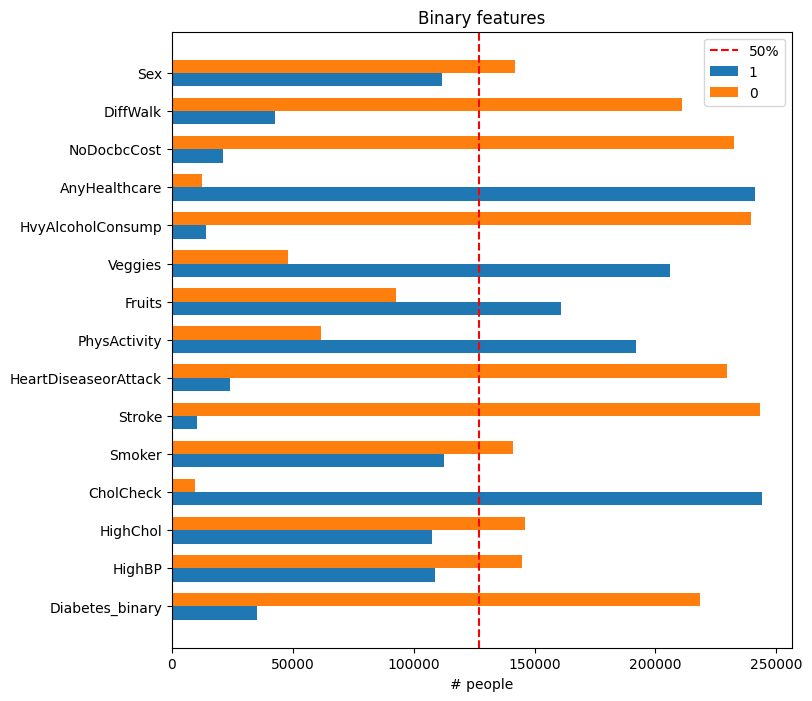

In [15]:
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html

bin_features = d_data.columns[d_data.nunique() == 2]
count_rows = d_data.shape[0]
positive_features = [d_data[i].sum() for i in bin_features]
negative_features = [count_rows - i for i in positive_features]

width = 0.35  # the width of the bars
x = np.arange(len(bin_features)) 

plt.barh(x- width/2, positive_features, width, label="1")
plt.barh(x+ width/2, negative_features, width, label="0")
plt.yticks(x, bin_features)
plt.axvline(count_rows/2, label="50%", c="r", ls="--")
plt.xlabel("# people")
plt.legend()
plt.title("Binary features")
plt.show()

*here $sex = 0$ denotes a female participant*

From this plot we could see a couple of things. 
* The data set is highly unbalanced - there are a lot more people with diabetes rather than people without. This means that when we build our model we will stratify the data in order to get the same proportion of people with diabetes and people without.
* The dataset is also unbalanced by gender. This could be relevant as many studies show that males are more susceptible to diabetes [[1]](https://www.statista.com/statistics/827815/diabetes-prevalence-us-adults-by-gender-and-type/) ,[[2]](https://www.news-medical.net/health/Diabetes-in-Men-versus-Women.aspx), [[3]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4890267/).Although we have to keep in mind that these figures vary country to country and in some studies women are more susceptible to diabetes [[4]](https://medcraveonline.com/JDMDC/the-ldquosecretrdquo-impact-of-population-statistics-on-the-metrics-of-diabetes.html). When we are building our model we will keep this in mind and we will stratify the data by sex as well
* We can see that our dataset contains people that are mostly physically active and eat healthy. We should also note that most of the people in this dataset have medical insurance and did not had a medical emergency in the past 12 months that they could not afford to treat. 

In [16]:
ratio = d_data.shape[0]/d_data["Diabetes_binary"].sum()
print("The ratio of people with diabetes to people with diabetes in this dataset is 1:{:.1f}".format(ratio))

The ratio of people with diabetes to people with diabetes in this dataset is 1:7.2


Now that we have established that the participants in the survey are mostly healthy individuals it is interesting to see the income distribution.

In [17]:
# from the description
i_labels = {1: "< 10 k",
            2: "< 15 k",
            3: "< 20 k",
            4: "< 25 k",
            5: "< 35 k",
            6: "< 50 k",
            7: "< 75 k",
            8: "> 75 k"}

i_cat, i_counts = np.unique(d_data["Income"], return_counts=True)
i_l_list = [i_labels[x] for x in i_cat]

plt.bar(i_cat, i_counts, align='center')

plt.title("Income distribution of participants")
plt.xlabel("Income, $")
plt.ylabel("# participants")
plt.xticks(i_cat, i_l_list)
plt.show()

As we can see the most represented group is people with income above \\$$75\ 000$. We can find find out that the median income for USA for the year is $2015$ is \\$$56\ 516$. It is interesting to see how our dataset compares to this.

In [18]:
median_i_bracket = np.median(d_data["Income"])
i_above_50k = ((d_data["Income"] == 7) | (d_data["Income"] == 8)).sum()
i_below_50k = d_data.shape[0] - i_above_50k
ratio = i_above_50k/i_below_50k

print("The median income bracket is {}.".format(i_labels[median_i_bracket]))
print("The ratio of below and above $50k is 1:{:.1f}".format(ratio))

The median income bracket is < 75 k.
The ratio of below and above $50k is 1:1.1


The ratio shows that in our dataset mostly representative of the income of the average american.

In [19]:
mental_health, mh_counts = np.unique(d_data["MentHlth"], return_counts=True)
phys_health, ph_counts = np.unique(d_data["PhysHlth"], return_counts=True)

width = 0.35
plt.bar(phys_health - width/2, ph_counts, width, align='center', label="Physical health")
plt.bar(mental_health + width/2, mh_counts, width, align='center', label="Mental health")

plt.title("Mental and Physical health last 30 days")
plt.ylabel("# participants")
plt.xlabel("Bad mental/physical health last 30 days")
plt.legend()
plt.show()

This plot suggest very strong correlation between the features but from before we saw that the correlation is only $0.35$. Most likely we can see the similarities in the values above $5$ days, because we have the tendency to round up numbers e.g. $5$, $10$, $15$... Likewise we can see more participants answering with multiples of $7$ e.g. $7$, $14$... 

In [20]:
# from the description
ed_labels = {
    1: "Never attended school",
    2: "Elementary",
    3: "Some high school",
    4: "High school graduate",
    5: "Some college or technical school",
    6: "College graduate"
}

ed_cat, ed_counts = np.unique(d_data["Education"], return_counts=True)
ed_l_list = [ed_labels[x] for x in ed_cat]

plt.barh(ed_cat, ed_counts, align='center')
plt.yticks(ed_cat, ed_l_list)
plt.title("Education level of participants")
plt.xlabel("# participants")
plt.show()

We can see that most of the participant have attended some kind of school. When we are looking at those figures it is important to note that some of the participants of the survey are in the age category $[18-24]$ and may have not yet finished their schooling.

In [21]:
no_hs = ((d_data["Education"] == 1) | (d_data["Education"] == 2)).sum()
hs_or_more = d_data.shape[0] - no_hs
ratio = hs_or_more/no_hs
print("the ratio of people who attended at least high school to those that did't is 1:{:.1f}".format(ratio))

the ratio of people who attended at least high school to those that did't is 1:59.2


It is interesting to see the age distribution of the participants as well.

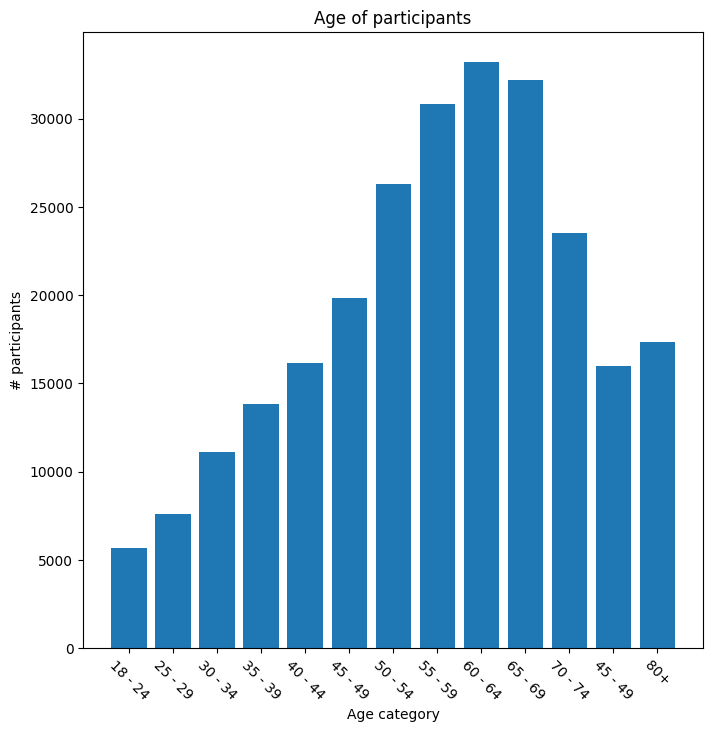

In [22]:
# from the description
age_labels = {
    1: "18 - 24",
    2: "25 - 29",
    3: "30 - 34",
    4: "35 - 39",
    5: "40 - 44",
    6: "45 - 49",
    7: "50 - 54",
    8: "55 - 59",
    9: "60 - 64",
    10: "65 - 69",
    11: "70 - 74",
    12: "45 - 49",
    13: "80+"
}

age_cat, age_counts = np.unique(d_data["Age"], return_counts=True)
age_l_list = [age_labels[x] for x in age_cat]

plt.bar(age_cat, age_counts, align='center')
plt.xticks(age_cat, age_l_list,rotation=315)
plt.title("Age of participants")
plt.ylabel("# participants")
plt.xlabel("Age category")
plt.show()

Here we can see that most of the participants are between $50$ and $70$ age with more people above $80$ than below $18$.

In [23]:
med_age = np.median(d_data["Age"])

print("The median age category of the dataset is {}.".format(age_labels[med_age]))

The median age category of the dataset is 55 - 59.


Lastly let's individualy look at the BMI index of the participants.

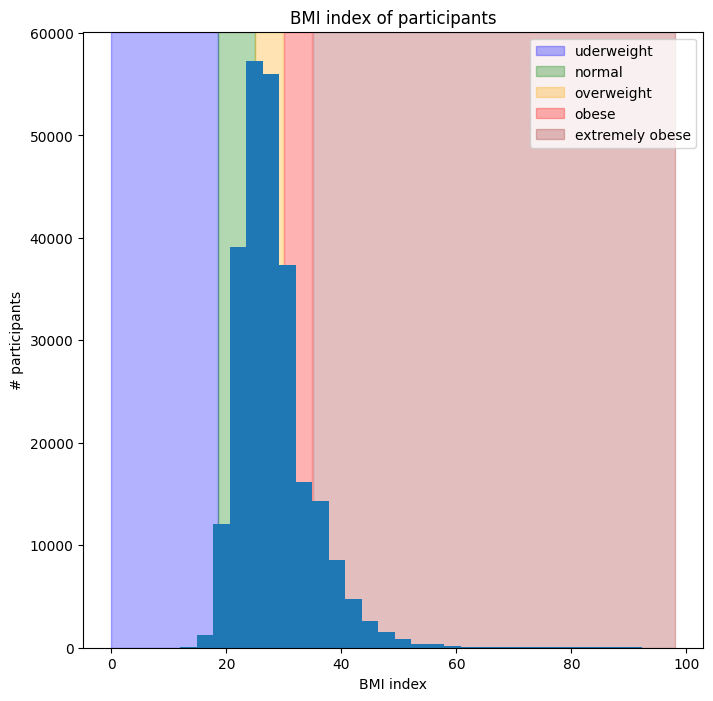

In [24]:
max_BMI = np.max(d_data["BMI"])

plt.axvspan(0, 18.5, color="blue", label="uderweight", alpha=0.3)
plt.axvspan(18.5, 24.9, color="green", label="normal", alpha=0.3)
plt.axvspan(25, 29.9, color="orange", label="overweight", alpha=0.3)
plt.axvspan(30, 34.9, color="red", label="obese", alpha=0.3)
plt.axvspan(35, max_BMI, color="brown", label="extremely obese", alpha=0.3)
plt.hist(d_data["BMI"], bins=30)

plt.legend()
plt.title("BMI index of participants")
plt.xlabel("BMI index")
plt.ylabel("# participants")
plt.show()

We can see that the data is skewed towards the higher BMI index. That is to be expected ([[1]](https://jamanetwork.com/journals/jama/fullarticle/2676543)) but let's see how closely our data resembles the study.

In [25]:
median_BMI = np.median(d_data["BMI"])

all_data = d_data.shape[0]

uderweight = (d_data["BMI"] < 18.5).sum() / all_data * 100
normal_weight = ((d_data["BMI"] >= 18.5) & (d_data["BMI"] < 25)).sum() / all_data * 100
overweight = ((d_data["BMI"] >= 25) & (d_data["BMI"] < 30)).sum() / all_data * 100
obese = ((d_data["BMI"] >= 30) & (d_data["BMI"] < 35)).sum() / all_data * 100
extremely_obese = (d_data["BMI"] >= 35).sum() / all_data * 100


print("{:.1f}% uderweight".format(uderweight))
print("{:.1f}% normal weight".format(normal_weight))
print("{:.1f}% overweight".format(overweight))
print("{:.1f}% obese".format(obese))
print("{:.1f}% extremely obese".format(extremely_obese))
print("")
print("The median BMI value is {}".format(median_BMI))

1.2% uderweight
27.2% normal weight
37.0% overweight
21.1% obese
13.6% extremely obese

The median BMI value is 27.0


Since we we don't expect a linear dependency between the BMI index and the risk of diabetes later in the notebook we will split the index into different categories.

Now let's see if we can see some dependencies between different features

In [26]:
sns.violinplot(data=d_data, x="Sex",y="Age", hue="Diabetes_binary",split=True)

plt.xlabel("Sex")
plt.xticks([0,1], ["Female", "Male"])
plt.yticks(age_cat, age_l_list)
plt.show()

In this plot we can see that females and males have very similar distributions by age and diabetes. Let's see if there are any differences if we use BMI rather than sex.

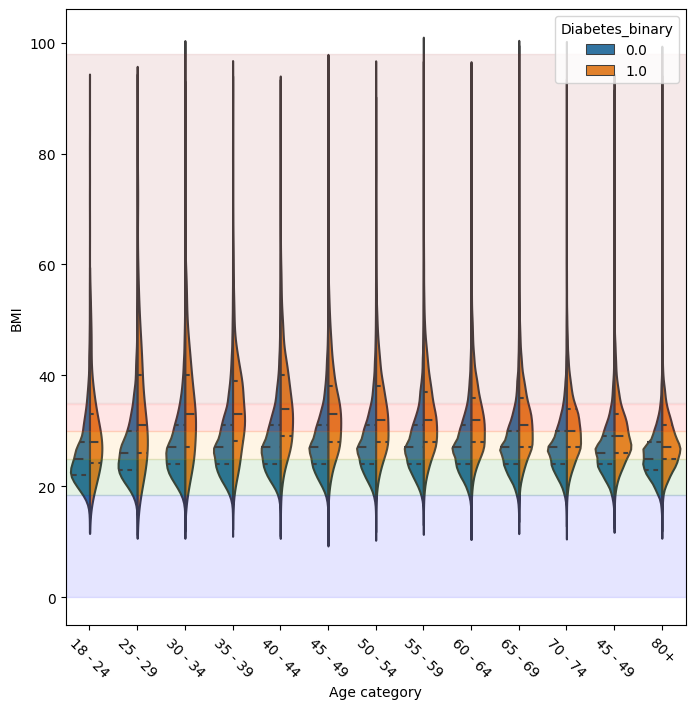

In [27]:
sns.violinplot(data=d_data, x="Age",y="BMI", hue="Diabetes_binary",split=True, inner="quartile" )

plt.axhspan(0, 18.5, color="blue", label="uderweight", alpha=0.1)
plt.axhspan(18.5, 24.9, color="green", label="normal", alpha=0.1)
plt.axhspan(25, 29.9, color="orange", label="overweight", alpha=0.1)
plt.axhspan(30, 34.9, color="red", label="obese", alpha=0.1)
plt.axhspan(35, max_BMI, color="brown", label="extremely obese", alpha=0.1)

plt.xlabel("Age category")
plt.xticks(age_cat-1, age_l_list,rotation=315)
plt.show()

*The BMI categories were color coded as in the previous plot*

In this plot can observe that the distribution of the BMI with ages for the people without diabetes stays visually the same with slight fluctuation of the median. The same cannot be said about the people with diabetes - the spread of the distribution varies greatly and so does the median value.
We can also see that the median BMI for people with diabetes is far greater with the exception of the age categories $18$-$24$ and $80$+.

https://www.news-medical.net/health/Diabetes-in-Men-versus-Women.aspx

## Modelling

Now that we have looked at the data we can start building our model.

### Splitting the data 

The first thing we have to do is split the attributes and labels from dataset.

In [28]:
d_attributes = d_data.drop("Diabetes_binary", axis=1)
d_labels = d_data["Diabetes_binary"]

Right after that we have to split the data into a training and a testing set. We have to do this before we do anything else in order to avoid data leakage. 

When we are building a model for some kind of disease it is a good idea to stratify the datasets by sex and race. Our dataset does not contain any information about the race of the participants but we cold still stratify the test and training sets by sex and the people with diabetes.

In [29]:
d_attributes_train, d_attributes_test, d_labels_train, d_labels_test = train_test_split(
    d_attributes,
    d_labels,
    stratify=pd.concat([d_labels, d_attributes["Sex"]], axis=1),
    test_size=0.2,
    shuffle=True)

We are using $20\%$ of the dataset for test samples, which should be enough.

In [30]:
whole_dataset_size = d_data.shape[0]

train_size = d_attributes_train.shape[0]
percent_train = train_size/whole_dataset_size

test_size = d_attributes_test.shape[0]
percent_test = test_size/whole_dataset_size

print("the whole dataset contains {} datapoints".format(whole_dataset_size))
print("the training dataset contains {} datapoints or {:.1} % of the whole dataset".format(train_size, percent_train))
print("the testing dataset contains {} datapoints or {:.1f} % of the whole dataset".format(test_size, percent_test))

the whole dataset contains 253680 datapoints
the training dataset contains 202944 datapoints or 0.8 % of the whole dataset
the testing dataset contains 50736 datapoints or 0.2 % of the whole dataset


### Preprocessing data 

even though our dataset consist mostly of binary or categorical features some preprocessing is still needed.  
Since the models that we are going to use, assume linear dependency between the features and the labels, we are going to split the `Age` categorical feature into separate columns(categorical one hot encoding). Similarly we are going to transform the the `BMI` feature into categories in according to its quantiles and then one-hot encode them.

In [31]:
age_column = ["Age"]
age_transformer = OneHotEncoder(categories="auto",drop="first",sparse=False)

BMI_column = ["BMI"]
BMI_transformer  = KBinsDiscretizer(n_bins=5, encode='onehot-dense',subsample=None, strategy='quantile')

column_transformer = ColumnTransformer(remainder="passthrough",
    transformers=[
        ("BMI", BMI_transformer, BMI_column),
        ("age", age_transformer, age_column),        
    ]
)
column_transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('BMI',
                                 KBinsDiscretizer(encode='onehot-dense',
                                                  subsample=None),
                                 ['BMI']),
                                ('age',
                                 OneHotEncoder(drop='first', sparse=False),
                                 ['Age'])])

You can see that for transformations we are going to use use `Pipelines`. They are a quite useful tool that help us  construct and visualize our workflow. Pipelines are also good tool when we are trying to avoid data leakage.

### Scaling the data

After we have have processed the columns in our dataset we should scale the data. Scaling the data is very important when we are constructing a model because some of the models are quite sensitive to scaled data [[1]](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html).

A simple example of this is when we have features like height and weight. A difference of $1$ (`sklearn` does not understand units) can have a different meaning - for a person a difference of one meter in height could be much more substantial than one kilogram.

There are many ways to scale our data (e.g. `MinMax`, `RobustScaler` `Standart`), but in our case we are going to use `StandartScaler`. This means that we are going standardize features by removing the mean and scaling to unit variance.

In [32]:
pipline_steps = [
    ('column transformer', column_transformer),
    ('scaler', StandardScaler()),
] 

preprocessor = Pipeline(pipline_steps)
preprocessor

Pipeline(steps=[('column transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('BMI',
                                                  KBinsDiscretizer(encode='onehot-dense',
                                                                   subsample=None),
                                                  ['BMI']),
                                                 ('age',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['Age'])])),
                ('scaler', StandardScaler())])

And that is how our preprocessing pipeline will look. Every time a model is fitted the pipeline will transform the features `BMI` and `Age` and than scale the data.

## Making a baseline estimator 

Now that we have managed our preprocessing we can make a baseline estimator to see how our model will perform without any additional parameter configurations(hyperparameter tuning).

In [33]:
pipline_steps = [
    ("column transofrmer", column_transformer),
    ("scaler", StandardScaler()),
    ('clf', DecisionTreeClassifier()),
] 

pipe = Pipeline(pipline_steps)
pipe.fit(d_attributes_train, d_labels_train)

Pipeline(steps=[('column transofrmer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('BMI',
                                                  KBinsDiscretizer(encode='onehot-dense',
                                                                   subsample=None),
                                                  ['BMI']),
                                                 ('age',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['Age'])])),
                ('scaler', StandardScaler()),
                ('clf', DecisionTreeClassifier())])

### Scoring

Now that we have fitted our model we can see how it preforms by calculating it's score.

In [34]:
pipe.score(d_attributes_test, d_labels_test)

0.8051087984862819

The scoring metric that is used when using `.score` by default is accuracy which has values $\in [0,1]$. The score is very good, but before we make any conclusions about the performance of our model it is a good idea to see the confusion matrix.

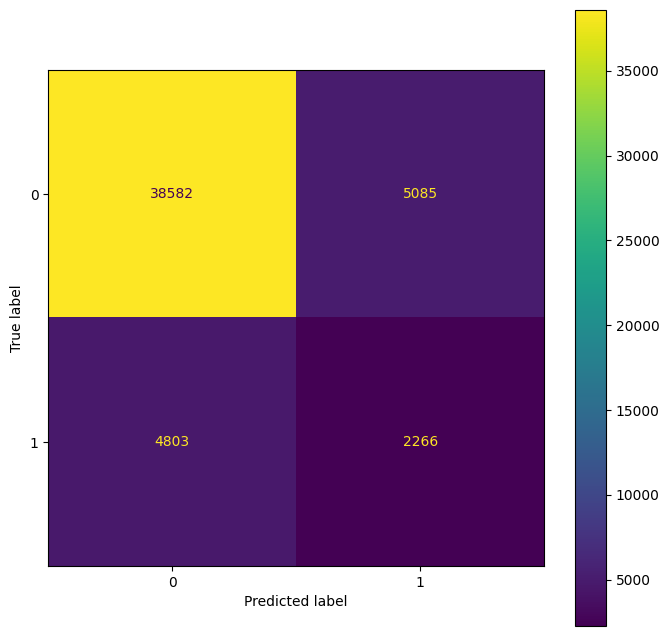

In [35]:
cm = confusion_matrix(d_labels_test, pipe.predict(d_attributes_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

It does not look so good. The model mainly classifies the data as negative (`Diabetes_binary` $= 0$). The misclassified positive labels are twice as much as the the correctly predicted ones.

Let's look at a more detailed score.

In [36]:
print(classification_report(d_labels_test,pipe.predict(d_attributes_test)))

              precision    recall  f1-score   support

         0.0       0.89      0.88      0.89     43667
         1.0       0.31      0.32      0.31      7069

    accuracy                           0.81     50736
   macro avg       0.60      0.60      0.60     50736
weighted avg       0.81      0.81      0.81     50736



Here we can see a few metrics of our fit. We can see that though our accuracy score is quite high some of the other scoring metrics suggest that our model does not perform so well.

### Different scoring metrics 

We are going to briefely go over some of the different scoring metrics but it is highly recommended that the reader has previously familiarized himself with them - [wikipedia article](https://en.wikipedia.org/wiki/Sensitivity_and_specificity).  

When we are talking about scoring we are going to use some definitions.
* $\mathrm{TP}$ - Labels that are positive and are classified as such
* $\mathrm{FP}$ - Labels that are positive but are classified as negative
* $\mathrm{TN}$ - Labels that are negative and are classified as such
* $\mathrm{FN}$ - Labels that are negative but are classified as positive

#####  Accuracy

Accuracy is the default scoring metric that is used in classification in `sklearn` it is defined as such.

$$\mathrm{Accuracy} = \frac{\mathrm{Correct \  predictions}}{\mathrm{All \  predictions}}$$

or

$$\mathrm{Accuracy} = \frac{\mathrm{TP} + \mathrm{TN}}{\mathrm{TP} + \mathrm{TN} + \mathrm{FP} + \mathrm{FN}}$$

This metric  gives us a basic idea of the performance of the model but could be often misleading such is in our case . Since accuracy is concerned only with the correctly labeled points, when we have unbalanced dataset the model could have a high score even if the model only returns the majority class.

#####  Sensitivity/Recall
This metric assesses the probability of a positive label to be classified as such or the ratio between the positively classified data and the positive data.

$$\mathrm{Recall} = \frac{\mathrm{TP}}{\mathrm{TP} + \mathrm{FN}}$$

This metric is often used for diagnostic tests (such as our model)

#####  Specificity
This metric assesses the probability of a negative label to be classified as such or the ratio between the negatively classified data and the negative data.

$$\mathrm{Specificity} = \frac{\mathrm{TN}}{\mathrm{TN} + \mathrm{FP}}$$

When we are modeling diagnostics of a disease there is usually a trade-off between recall and specificity - when the model has high recall ratio the specificity is lower and vice versa. 

#####  Precision/Positive predictive value
This metric assesses how much we can trust a given prediction. It is the ratio between true positive data and all the data labeled as positive(false and true)

$$\mathrm{Accuracy} = \frac{\mathrm{TP}}{\mathrm{TP} + \mathrm{FP}}$$

A model with good specificity score has a lower chance of misclassifying data as positive.

#####  Balanced accuracy

Balanced accuracy is a metric that is often used with imbalanced datasets. It accounts bout for the positive and negative outcome of the classes and dosen't mislead with imbalanced data.

$$\mathrm{Balanced \  accuracy} = \frac{\mathrm{Specificity}+\mathrm{Recall}}{2}$$

This metric is used in unbalanced classification problems where the positive and the negative values are equally important.  

#####  $\mathrm{F}_1\mathrm{/F}_\beta$ score

The $\mathrm{F}_1$ score is defined as the harmonic mean of the precision and recall.

$$\mathrm{F}_1 = \frac{\mathrm{Precision}*\mathrm{Recall}}{\mathrm{Precision}+\mathrm{Recall}} = \frac{2\mathrm{TP}}{2\mathrm{TP}+\mathrm{FP} + \mathrm{FN}}$$

This metric is quite useful in our case, because it could be used in unbalanced datasets and it puts a grater importance of the positive label. In our case this is very beneficial because diabetes could do a lot of harm if left unchecked.

A more general version of the $\mathrm{F}_1$ score is the $\mathrm{F}_\beta$ score, where the contribution ratio of precision and recall is given by a coefficient $\beta$.

$$ \mathrm{F}_\beta = (1+\beta^2)\frac{\mathrm{Precision}*\mathrm{Recall}}{\beta^2\mathrm{Precision}+\mathrm{Recall}}$$

In the case of a deadly disease usually a higher $\beta$ is used. In our case we will use $\beta=1$ or the $\mathrm{F_1}$ score

<!-- 

##### Diagnostic odds ratio

$$\mathrm{DOR} = \frac{\mathrm{TP}*\mathrm{TN}}{\mathrm{FP} * \mathrm{FN}}$$ -->

Now that we have introduced some other scoring metrics let's look at the $\mathrm{F}_1$ for example.

In [37]:
recall_score(d_labels_test,pipe.predict(d_attributes_test))

0.3205545338803225

This is not a very good score. In order to improve our model we have to try different parameters that are used - this process is called hyperparameter tuning.

## Lets build some models

Before we start building models we have to introduce a few concepts.

#### Cross validation and stratisfied cross validation

Cross validation is a method that uses different portions of the data set to test the model on different interactions. It is mainly used when we want to asses how accurately a model will perform with new data(test set).
This could be represented visually quite well.

![title](img/grid_search_cross_validation.png)
*source [sklearn](https://scikit-learn.org/stable/modules/cross_validation.html)*

In [38]:
k_fold = StratifiedKFold(n_splits=3)

In our case we will be splitting our data in just $3$ splits and we will be using `StratifiedKFold` to ensure that the percentage of positive labels remains the same in the splits. 

#### GridSearchCV, HalvingGridSearchCV

Grid search is a method in which different set of parameters are tested on a given model and then the model is scored with a selected metric.

Here is a diagram of the workflow using grid search and cross validation

![title](img/grid_search_workflow.png)
*source [sklearn](https://scikit-learn.org/stable/modules/cross_validation.html)*

In this project we will be using `HalvingGridSearchCV` rather than `GridSearchCV`. The difference between the two functions is that the first one is an iterative algorithm which tests the models and their parameters on a smaller portion of the data and proceeds to remove the ones with the worst performace. This is repeated until the final models are tested with the whole data. This is quite helpful when we want to reduce the time for evaluation or the computing resources.

After we have fitted a model it is very convenient to save it. That is why we will build a function that checks if the model has been previously fitted and saved. If the model is available it is loaded, otherwise the function will fit and save it.

In [39]:
save_folder = "saved_models/"
file_extension = ".sav"

def fit_pipe(pipe,
             train_atributes,
             train_labels,
             name,
             load_if_pickle_exists=True,
             save_pickle = True,
             save_folder=save_folder,
             file_extension=file_extension):
    """
    pipe                  - Pipe to be fitted
    train_atributes       - atributes on which the pipe to be trained
    train_labels          - labels on which the pipe to be trained
    name                  - name of the file to load/ save the pickle file
    load_if_pickle_exists - if True loads the pickle dump, rather than fitting the pipe
    save_pickle           - if true saves the fitted pipe
    save_folder           - destination to save/load the pickle file 
    file_extension        - extension of the pickle file to save/load
    
    returns               - fitted  pipeline
    """

    filename = save_folder + name + file_extension
    
    if (exists(filename)) & load_if_pickle_exists:
        pipe = pickle.load(open(filename, 'rb'))
    else:
        pipe.fit(train_atributes, train_labels)
        if save_pickle:
            print(filename)
            pickle.dump(pipe, open(filename, 'wb'))

    return pipe

Now let's build and fit our grid search.

In [40]:
classifier = DecisionTreeClassifier()
grid = {"clf__criterion": ["gini", "entropy", "log_loss"],
        "clf__max_depth": [20, 50, 100, 500, None],
        "clf__min_samples_leaf": [2, 20, 100, 500, 1000],
        "clf__splitter": ["best", "random"],
        "clf__class_weight": [None, "balanced"]
        }

pipline_steps = [
    ("column transofrmer", column_transformer),
    ("scaler", StandardScaler()),
    ('clf', classifier)
]

pipe = Pipeline(pipline_steps)

grid_search = HalvingGridSearchCV(estimator=pipe,
                                  param_grid=grid,
                                  scoring='f1',
                                  cv=k_fold,
                                  n_jobs=-1,
                                  verbose=0,
                                  refit=True)

grid_search = fit_pipe(grid_search, d_attributes_train, d_labels_train, name="dt")
grid_search

HalvingGridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                    estimator=Pipeline(steps=[('column transofrmer',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('BMI',
                                                                                KBinsDiscretizer(encode='onehot-dense',
                                                                                                 subsample=None),
                                                                                ['BMI']),
                                                                               ('age',
                                                                                OneHotEncoder(drop='first',
                                                                                              sparse=False),
                                                                                ['Age'])])),
                                              ('scaler', StandardScaler()),
                                              ('clf',
                                               DecisionTreeClassifier())]),
                    n_jobs=-1,
                    param_grid={'clf__class_weight': [None, 'balanced'],
                                'clf__criterion': ['gini', 'entropy',
                                                   'log_loss'],
                                'clf__max_depth': [20, 50, 100, 500, None],
                                'clf__min_samples_leaf': [2, 20, 100, 500,
                                                          1000],
                                'clf__splitter': ['best', 'random']},
                    scoring='f1')

It is important to note the parameter `refit`. When the value is set to `True` after finding the best hyperparameters, the whole data(without using cross validation splits) is refitted. This means that there are no additional steps required to take in order to score the test set with our model.

The fitted pipeline looks good. Now let's see the results of the model

In [41]:
# index of the best model
best_model_index = grid_search.best_index_

# get the results of the best fit
test_score = grid_search.cv_results_["mean_test_score"][best_model_index]
std_test = grid_search.cv_results_["std_test_score"][best_model_index]

print(u"f1 score of the best estimator is {:.3f} \u00B1 {:.4f}".format(test_score,std_test))

f1 score of the best estimator is 0.420 ± 0.0035


We can see that our model has improved substantially We could also see the parameters that yield the best results.

In [42]:
grid_search.best_params_

{'clf__class_weight': 'balanced',
 'clf__criterion': 'gini',
 'clf__max_depth': 100,
 'clf__min_samples_leaf': 100,
 'clf__splitter': 'random'}

In our case after the grid search we will not be modifying our any further our models so we could make predictions on the test dataset and calculate some scoring metrics, that we could use in the final selection of our model. 

In [43]:
test_prediction = grid_search.predict(d_attributes_test)

rs = recall_score(d_labels_test, test_prediction)
ps = precision_score(d_labels_test, test_prediction)
bas = balanced_accuracy_score(d_labels_test, test_prediction)
f1s = f1_score(d_labels_test, test_prediction)

print("recall score is {:.3f}".format(rs))
print("precision score is {:.3f}".format(ps))
print("balanced accuracy score is {:.3f}".format(bas))
print("f1 score is {:.3f}".format(f1s))

recall score is 0.775
precision score is 0.293
balanced accuracy score is 0.736
f1 score is 0.426


#### Creating a dataframe with model results

In order to compare easily results we will put the models and the scoring in a `pandas` dataframe. 

In [44]:
models_score = pd.DataFrame(columns=["model_descr", "optimisation_metric", "recall",
                                     "precision", "f1", "balanced_accuracy", "model"])

It will be very useful to create a function that extracts the data from our fitted pipeline and puts it in the dataframe

In [45]:
def extract_model_score(fiited_grid_search, description, attributes_test, labels_test):
    """
    fiited_grid_search - fitted grid search used in the scoring
    description        - breaf description of the model
    attributes_test    - atributes to score
    labels_test        - labels to score
    
    returns            - None
    """
    scoring = fiited_grid_search.scoring
    model = fiited_grid_search.best_estimator_
    
    test_prediction = grid_search.predict(d_attributes_test)

    rs = recall_score(d_labels_test, test_prediction)
    ps = precision_score(d_labels_test, test_prediction)
    bas = balanced_accuracy_score(d_labels_test, test_prediction)
    f1s = f1_score(d_labels_test, test_prediction)

    model_result = [description, scoring, rs, ps, f1s, bas, model]   
    models_score.loc[len(models_score)] = model_result

In [46]:
extract_model_score(grid_search, "DecisionTreeClassifier", d_attributes_test, d_labels_test)
models_score

model_descr optimisation_metric    recall  precision        f1  \
0  DecisionTreeClassifier                  f1  0.774508   0.293377  0.425557   

   balanced_accuracy                                              model  
0           0.736259  (ColumnTransformer(remainder='passthrough',\n ...

#### Make a function for testing models

Now let's simplify the creation of the pipeline and create a function that does just that.

In [47]:
def create_grid_search(classifier,
                       param_grid,
                       sampling=None,
                       Is_HalvingGridSearchCV=True,
                       scoring="f1",
                       verbose=0):
    """
    classifier             - clasifier to be used in the grid search
    param_grid             - params of the grid search 
    sampling               - sampling to be used 
    Is_HalvingGridSearchCV - if True uses HalvingGridSearchCV rather than GridSearchCV
    scoring                - scoring to be used 
    verbose                - verbose grid search
    
    returns                - returns the grid_search pipe
    """

    pipline_steps = [
        ("column transofrmer", column_transformer),
        ("scaler", StandardScaler()),
        ('clf', classifier)
    ]

    if sampling:
        pipline_steps.insert(2, ('sampling', sampling))

    pipe = Pipeline(pipline_steps, memory="pipe_cashe")

    if Is_HalvingGridSearchCV:
        grid_search = HalvingGridSearchCV(estimator=pipe,
                                          param_grid=param_grid,
                                          scoring=scoring,
                                          cv=k_fold,
                                          n_jobs=-1,
                                          verbose=0,
                                          refit=True)
    else:
        grid_search = GridSearchCV(estimator=pipe,
                                   param_grid=param_grid,
                                   scoring=scoring,
                                   cv=k_fold,
                                   n_jobs=-1,
                                   verbose=0,
                                   refit=True)

    return grid_search

For now we will not use the parameter `sampling` - we will use it later on when we try different sample techniques in order to improve our scoring. 


Now let's try to fit the data with a `LogisticRegression` model. 

In [48]:
# remove the ConvergenceWarning errors
warnings.filterwarnings('ignore', category=ConvergenceWarning)

In [49]:
classifier = LogisticRegression(penalty='elasticnet', solver='saga', max_iter=1500)
grid = {
    "clf__C": [1e-6, 1e-3, 1e-2, 0.1, 1, 10, 1e3, 1e6, 1e9],
    "clf__l1_ratio": [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    "clf__fit_intercept": [True, False],
    "clf__class_weight": [None, "balanced"]
}

grid_search = create_grid_search(classifier=classifier, param_grid=grid)
grid_search = fit_pipe(grid_search, d_attributes_train, d_labels_train, name="lr")
grid_search

HalvingGridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                    estimator=Pipeline(memory='pipe_cashe',
                                       steps=[('column transofrmer',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('BMI',
                                                                                KBinsDiscretizer(encode='onehot-dense',
                                                                                                 subsample=None),
                                                                                ['BMI']),
                                                                               ('age',
                                                                                OneHotEncoder(drop='first',
                                                                                              sparse=False),
                                                                                ['Age'])])),
                                              ('scaler', StandardScaler()),
                                              ('clf',
                                               LogisticRegression(max_iter=1500,
                                                                  penalty='elasticnet',
                                                                  solver='saga'))]),
                    n_jobs=-1,
                    param_grid={'clf__C': [1e-06, 0.001, 0.01, 0.1, 1, 10,
                                           1000.0, 1000000.0, 1000000000.0],
                                'clf__class_weight': [None, 'balanced'],
                                'clf__fit_intercept': [True, False],
                                'clf__l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                  0.6, 0.7, 0.8, 0.9, 1]},
                    scoring='f1')

In [50]:
extract_model_score(grid_search, "LogisticRegression", d_attributes_test, d_labels_test)
models_score

model_descr optimisation_metric    recall  precision        f1  \
0  DecisionTreeClassifier                  f1  0.774508   0.293377  0.425557   
1      LogisticRegression                  f1  0.777904   0.312674  0.446058   

   balanced_accuracy                                              model  
0           0.736259  (ColumnTransformer(remainder='passthrough',\n ...  
1           0.750541  (ColumnTransformer(remainder='passthrough',\n ...

Another model we could try is `RandomForestClassifier`

In [51]:
classifier = RandomForestClassifier()
grid = {
    "clf__criterion": ["gini", "entropy", "log_loss"],
    "clf__n_estimators": [10, 50, 100, 200],
    "clf__min_samples_split": [2, 5, 50, 100],
    "clf__min_samples_leaf": [1, 20, 100, 500],
    "clf__class_weight": [None, "balanced"]
}

grid_search = create_grid_search(classifier=classifier, param_grid=grid)
grid_search = fit_pipe(grid_search, d_attributes_train, d_labels_train, name="rfc")
grid_search

HalvingGridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                    estimator=Pipeline(memory='pipe_cashe',
                                       steps=[('column transofrmer',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('BMI',
                                                                                KBinsDiscretizer(encode='onehot-dense',
                                                                                                 subsample=None),
                                                                                ['BMI']),
                                                                               ('age',
                                                                                OneHotEncoder(drop='first',
                                                                                              sparse=False),
                                                                                ['Age'])])),
                                              ('scaler', StandardScaler()),
                                              ('clf',
                                               RandomForestClassifier())]),
                    n_jobs=-1,
                    param_grid={'clf__class_weight': [None, 'balanced'],
                                'clf__criterion': ['gini', 'entropy',
                                                   'log_loss'],
                                'clf__min_samples_leaf': [1, 20, 100, 500],
                                'clf__min_samples_split': [2, 5, 50, 100],
                                'clf__n_estimators': [10, 50, 100, 200]},
                    scoring='f1')

In [52]:
extract_model_score(grid_search, "RandomForestClassifier", d_attributes_test, d_labels_test)
models_score

model_descr optimisation_metric    recall  precision        f1  \
0  DecisionTreeClassifier                  f1  0.774508   0.293377  0.425557   
1      LogisticRegression                  f1  0.777904   0.312674  0.446058   
2  RandomForestClassifier                  f1  0.709294   0.334735  0.454826   

   balanced_accuracy                                              model  
0           0.736259  (ColumnTransformer(remainder='passthrough',\n ...  
1           0.750541  (ColumnTransformer(remainder='passthrough',\n ...  
2           0.740545  (ColumnTransformer(remainder='passthrough',\n ...

#### Ensemble methods

Ensemble estimators combine several base estimators in a algorithm in order to improve it. The ensemble method that we are going to use is `AdaBoostClassifier` which is a boosting method where several base estimators are build in order to improve the model.

In [53]:
classifier = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())
grid = {
    "clf__n_estimators": [10, 50, 100, 500],
    "clf__learning_rate": [0.0001, 0.001, 0.01, 0.1, 1.0],
    "clf__base_estimator__class_weight": [None, "balanced"],
    "clf__base_estimator__max_depth": [1, 2, 5, 10],
}

grid_search = create_grid_search(classifier=classifier, param_grid=grid)
grid_search = fit_pipe(grid_search, d_attributes_train, d_labels_train, name="ab_dt")
grid_search

HalvingGridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                    estimator=Pipeline(memory='pipe_cashe',
                                       steps=[('column transofrmer',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('BMI',
                                                                                KBinsDiscretizer(encode='onehot-dense',
                                                                                                 subsample=None),
                                                                                ['BMI']),
                                                                               ('age',
                                                                                OneHotEncoder(drop='first',
                                                                                              sparse=False),
                                                                                ['Age'])])),
                                              ('scaler', StandardScaler()),
                                              ('clf',
                                               AdaBoostClassifier(base_estimator=DecisionTreeClassifier()))]),
                    n_jobs=-1,
                    param_grid={'clf__base_estimator__class_weight': [None,
                                                                      'balanced'],
                                'clf__base_estimator__max_depth': [1, 2, 5, 10],
                                'clf__learning_rate': [0.0001, 0.001, 0.01, 0.1,
                                                       1.0],
                                'clf__n_estimators': [10, 50, 100, 500]},
                    scoring='f1')

In [54]:
extract_model_score(grid_search, "AdaBoostClassifier + DecisionTreeClassifier", d_attributes_test, d_labels_test)
models_score

model_descr optimisation_metric    recall  \
0                       DecisionTreeClassifier                  f1  0.774508   
1                           LogisticRegression                  f1  0.777904   
2                       RandomForestClassifier                  f1  0.709294   
3  AdaBoostClassifier + DecisionTreeClassifier                  f1  0.778328   

   precision        f1  balanced_accuracy  \
0   0.293377  0.425557           0.736259   
1   0.312674  0.446058           0.750541   
2   0.334735  0.454826           0.740545   
3   0.312720  0.446174           0.750707   

                                               model  
0  (ColumnTransformer(remainder='passthrough',\n ...  
1  (ColumnTransformer(remainder='passthrough',\n ...  
2  (ColumnTransformer(remainder='passthrough',\n ...  
3  (ColumnTransformer(remainder='passthrough',\n ...

Now let's see the results for `AdaBoostClassifier + LogisticRegression`

In [55]:
classifier = AdaBoostClassifier(base_estimator=LogisticRegression(penalty='elasticnet', solver='saga'))
grid = {"clf__n_estimators": [10, 50, 100, 500],
        "clf__learning_rate": [0.0001, 0.001, 0.01, 0.1, 1.0],
        "clf__base_estimator__class_weight":[None, "balanced"],
        "clf__base_estimator__l1_ratio": [0,  0.3, 0.6, 1],
       }


grid_search = create_grid_search(classifier=classifier, param_grid=grid)
grid_search = fit_pipe(grid_search, d_attributes_train, d_labels_train, name="ab_lr")
grid_search

HalvingGridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                    estimator=Pipeline(memory='pipe_cashe',
                                       steps=[('column transofrmer',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('BMI',
                                                                                KBinsDiscretizer(encode='onehot-dense',
                                                                                                 subsample=None),
                                                                                ['BMI']),
                                                                               ('age',
                                                                                OneHotEncoder(drop='first',
                                                                                              sparse=False),
                                                                                ['Age'])])),
                                              ('scaler', StandardScaler()),
                                              ('clf',
                                               AdaBoostClassifier(base_estimator=LogisticRegression(penalty='elasticnet',
                                                                                                    solver='saga')))]),
                    n_jobs=-1,
                    param_grid={'clf__base_estimator__class_weight': [None,
                                                                      'balanced'],
                                'clf__base_estimator__l1_ratio': [0, 0.3, 0.6,
                                                                  1],
                                'clf__learning_rate': [0.0001, 0.001, 0.01, 0.1,
                                                       1.0],
                                'clf__n_estimators': [10, 50, 100, 500]},
                    scoring='f1')

In [56]:
extract_model_score(grid_search, "AdaBoostClassifier + LogisticRegression", d_attributes_test, d_labels_test)
models_score

model_descr optimisation_metric    recall  \
0                       DecisionTreeClassifier                  f1  0.774508   
1                           LogisticRegression                  f1  0.777904   
2                       RandomForestClassifier                  f1  0.709294   
3  AdaBoostClassifier + DecisionTreeClassifier                  f1  0.778328   
4      AdaBoostClassifier + LogisticRegression                  f1  0.770406   

   precision        f1  balanced_accuracy  \
0   0.293377  0.425557           0.736259   
1   0.312674  0.446058           0.750541   
2   0.334735  0.454826           0.740545   
3   0.312720  0.446174           0.750707   
4   0.315126  0.447292           0.749677   

                                               model  
0  (ColumnTransformer(remainder='passthrough',\n ...  
1  (ColumnTransformer(remainder='passthrough',\n ...  
2  (ColumnTransformer(remainder='passthrough',\n ...  
3  (ColumnTransformer(remainder='passthrough',\n ...  
4  (ColumnTransformer(remainder='passthrough',\n ...

### Under/oversampling

Another thing we can do to toggle with the modeling of unbalanced data is using different sampling techniques.

#### Random undersampling 

When using `RandomUnderSampler`, we are subsampling the majority class(people without diabetes) in order to create a balanced fold on which our model will be fitted to.

Let's fit our previous models in order to see if there is any improvement.

In [57]:
classifier = DecisionTreeClassifier()
grid = {
    "clf__criterion": ["gini", "entropy", "log_loss"],
    "clf__max_depth": [20, 50, 100, 500, None],
    "clf__min_samples_leaf": [2, 20, 100, 500, 1000],
    "clf__splitter": ["best", "random"]
}
sampler = RandomUnderSampler()

grid_search = create_grid_search(classifier=classifier, param_grid=grid, sampling=sampler)
grid_search = fit_pipe(grid_search, d_attributes_train, d_labels_train, name="us_dt")
grid_search

HalvingGridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                    estimator=Pipeline(memory='pipe_cashe',
                                       steps=[('column transofrmer',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('BMI',
                                                                                KBinsDiscretizer(encode='onehot-dense',
                                                                                                 subsample=None),
                                                                                ['BMI']),
                                                                               ('age',
                                                                                OneHotEncoder(drop='first',
                                                                                              sparse=False),
                                                                                ['Age'])])),
                                              ('scaler', StandardScaler()),
                                              ('sampling',
                                               RandomUnderSampler()),
                                              ('clf',
                                               DecisionTreeClassifier())]),
                    n_jobs=-1,
                    param_grid={'clf__criterion': ['gini', 'entropy',
                                                   'log_loss'],
                                'clf__max_depth': [20, 50, 100, 500, None],
                                'clf__min_samples_leaf': [2, 20, 100, 500,
                                                          1000],
                                'clf__splitter': ['best', 'random']},
                    scoring='f1')

In [58]:
extract_model_score(grid_search, "RandomUnderSampler + DecisionTreeClassifier", d_attributes_test, d_labels_test)
models_score.tail(3)

model_descr optimisation_metric    recall  \
3  AdaBoostClassifier + DecisionTreeClassifier                  f1  0.778328   
4      AdaBoostClassifier + LogisticRegression                  f1  0.770406   
5  RandomUnderSampler + DecisionTreeClassifier                  f1  0.771962   

   precision        f1  balanced_accuracy  \
3   0.312720  0.446174           0.750707   
4   0.315126  0.447292           0.749677   
5   0.295005  0.426878           0.736658   

                                               model  
3  (ColumnTransformer(remainder='passthrough',\n ...  
4  (ColumnTransformer(remainder='passthrough',\n ...  
5  (ColumnTransformer(remainder='passthrough',\n ...

Now let's fit the `LogisticRegression` model.

In [59]:
classifier = LogisticRegression(penalty='elasticnet', solver='saga', max_iter=1500)
grid = {
    "clf__C": [1e-6, 1e-3, 1e-2, 0.1, 1, 10, 1e3, 1e6, 1e9],
    "clf__l1_ratio": [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    "clf__fit_intercept": [True, False]
}
sampler = RandomUnderSampler()

grid_search = create_grid_search(classifier=classifier, param_grid=grid, sampling=sampler)
grid_search = fit_pipe(grid_search, d_attributes_train, d_labels_train, name="us_lr")
grid_search

HalvingGridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                    estimator=Pipeline(memory='pipe_cashe',
                                       steps=[('column transofrmer',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('BMI',
                                                                                KBinsDiscretizer(encode='onehot-dense',
                                                                                                 subsample=None),
                                                                                ['BMI']),
                                                                               ('age',
                                                                                OneHotEncoder(drop='first',
                                                                                              sparse=False),
                                                                                ['Age'])])),
                                              ('scaler', StandardScaler()),
                                              ('sampling',
                                               RandomUnderSampler()),
                                              ('clf',
                                               LogisticRegression(max_iter=1500,
                                                                  penalty='elasticnet',
                                                                  solver='saga'))]),
                    n_jobs=-1,
                    param_grid={'clf__C': [1e-06, 0.001, 0.01, 0.1, 1, 10,
                                           1000.0, 1000000.0, 1000000000.0],
                                'clf__fit_intercept': [True, False],
                                'clf__l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                  0.6, 0.7, 0.8, 0.9, 1]},
                    scoring='f1')

In [60]:
extract_model_score(grid_search, "RandomUnderSampler + LogisticRegression", d_attributes_test, d_labels_test)
models_score.tail(3)

model_descr optimisation_metric    recall  \
4      AdaBoostClassifier + LogisticRegression                  f1  0.770406   
5  RandomUnderSampler + DecisionTreeClassifier                  f1  0.771962   
6      RandomUnderSampler + LogisticRegression                  f1  0.777762   

   precision        f1  balanced_accuracy  \
4   0.315126  0.447292           0.749677   
5   0.295005  0.426878           0.736658   
6   0.312955  0.446321           0.750676   

                                               model  
4  (ColumnTransformer(remainder='passthrough',\n ...  
5  (ColumnTransformer(remainder='passthrough',\n ...  
6  (ColumnTransformer(remainder='passthrough',\n ...

And the `RandomForestClassifier`.

In [61]:
classifier = RandomForestClassifier()
grid = {
    "clf__criterion": ["gini", "entropy", "log_loss"],
    "clf__n_estimators": [10, 50, 100, 150, 200],
    "clf__min_samples_split": [2, 5, 50, 100, 500],
    "clf__min_samples_leaf": [1, 20, 100, 500, 800]
}

sampler = RandomUnderSampler()

grid_search = create_grid_search(classifier=classifier, param_grid=grid, sampling=sampler)
grid_search = fit_pipe(grid_search, d_attributes_train, d_labels_train, name="us_rf")
grid_search

HalvingGridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                    estimator=Pipeline(memory='pipe_cashe',
                                       steps=[('column transofrmer',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('BMI',
                                                                                KBinsDiscretizer(encode='onehot-dense',
                                                                                                 subsample=None),
                                                                                ['BMI']),
                                                                               ('age',
                                                                                OneHotEncoder(drop='first',
                                                                                              sparse=False),
                                                                                ['Age'])])),
                                              ('scaler', StandardScaler()),
                                              ('sampling',
                                               RandomUnderSampler()),
                                              ('clf',
                                               RandomForestClassifier())]),
                    n_jobs=-1,
                    param_grid={'clf__criterion': ['gini', 'entropy',
                                                   'log_loss'],
                                'clf__min_samples_leaf': [1, 20, 100, 500, 800],
                                'clf__min_samples_split': [2, 5, 50, 100, 500],
                                'clf__n_estimators': [10, 50, 100, 150, 200]},
                    scoring='f1')

In [62]:
extract_model_score(grid_search, "RandomUnderSampler + RandomForestClassifier", d_attributes_test, d_labels_test)
models_score.tail(3)

model_descr optimisation_metric    recall  \
5  RandomUnderSampler + DecisionTreeClassifier                  f1  0.771962   
6      RandomUnderSampler + LogisticRegression                  f1  0.777762   
7  RandomUnderSampler + RandomForestClassifier                  f1  0.791060   

   precision        f1  balanced_accuracy  \
5   0.295005  0.426878           0.736658   
6   0.312955  0.446321           0.750676   
7   0.303484  0.438674           0.748577   

                                               model  
5  (ColumnTransformer(remainder='passthrough',\n ...  
6  (ColumnTransformer(remainder='passthrough',\n ...  
7  (ColumnTransformer(remainder='passthrough',\n ...

We could try to use `RandomUnderSampler` with `AdaBoostClassifier`.

In [63]:
classifier = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())
grid = {
    "clf__n_estimators": [10, 50, 100, 500],
    "clf__learning_rate": [0.0001, 0.001, 0.01, 0.1, 1.0],
    "clf__base_estimator__class_weight": [None, "balanced"],
    "clf__base_estimator__max_depth": [1, 2, 5, 10],
}
sampler = RandomUnderSampler()

grid_search = create_grid_search(classifier=classifier, param_grid=grid, sampling=sampler)
grid_search = fit_pipe(grid_search, d_attributes_train, d_labels_train, name="us_ab_rf")
grid_search

HalvingGridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                    estimator=Pipeline(memory='pipe_cashe',
                                       steps=[('column transofrmer',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('BMI',
                                                                                KBinsDiscretizer(encode='onehot-dense',
                                                                                                 subsample=None),
                                                                                ['BMI']),
                                                                               ('age',
                                                                                OneHotEncoder(drop='first',
                                                                                              sparse=False),
                                                                                ['Age'])])),
                                              ('scaler', StandardScaler()),
                                              ('sampling',
                                               RandomUnderSampler()),
                                              ('clf',
                                               AdaBoostClassifier(base_estimator=DecisionTreeClassifier()))]),
                    n_jobs=-1,
                    param_grid={'clf__base_estimator__class_weight': [None,
                                                                      'balanced'],
                                'clf__base_estimator__max_depth': [1, 2, 5, 10],
                                'clf__learning_rate': [0.0001, 0.001, 0.01, 0.1,
                                                       1.0],
                                'clf__n_estimators': [10, 50, 100, 500]},
                    scoring='f1')

In [64]:
extract_model_score(grid_search, "RandomUnderSampler + AdaBoostClassifier + DecisionTreeClassifier", d_attributes_test, d_labels_test)
models_score.tail(3)

model_descr optimisation_metric  \
6            RandomUnderSampler + LogisticRegression                  f1   
7        RandomUnderSampler + RandomForestClassifier                  f1   
8  RandomUnderSampler + AdaBoostClassifier + Deci...                  f1   

     recall  precision        f1  balanced_accuracy  \
6  0.777762   0.312955  0.446321           0.750676   
7  0.791060   0.303484  0.438674           0.748577   
8  0.775216   0.311434  0.444354           0.748876   

                                               model  
6  (ColumnTransformer(remainder='passthrough',\n ...  
7  (ColumnTransformer(remainder='passthrough',\n ...  
8  (ColumnTransformer(remainder='passthrough',\n ...

In [65]:
classifier = AdaBoostClassifier(base_estimator=LogisticRegression(penalty='elasticnet', solver='saga'))
grid = {"clf__n_estimators": [10, 50, 100, 500],
        "clf__learning_rate": [0.0001, 0.001, 0.01, 0.1, 1.0],
        "clf__base_estimator__class_weight":[None, "balanced"],
        "clf__base_estimator__l1_ratio": [0,  0.3, 0.6, 1],
       }
sampler = RandomUnderSampler()

grid_search = create_grid_search(classifier=classifier, param_grid=grid, sampling=sampler)
grid_search = fit_pipe(grid_search, d_attributes_train, d_labels_train, name="us_ab_lr")
grid_search

HalvingGridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                    estimator=Pipeline(memory='pipe_cashe',
                                       steps=[('column transofrmer',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('BMI',
                                                                                KBinsDiscretizer(encode='onehot-dense',
                                                                                                 subsample=None),
                                                                                ['BMI']),
                                                                               ('age',
                                                                                OneHotEncoder(drop='first',
                                                                                              sparse=False),
                                                                                ['Age'])])),
                                              ('scaler', Sta...
                                              ('sampling',
                                               RandomUnderSampler()),
                                              ('clf',
                                               AdaBoostClassifier(base_estimator=LogisticRegression(penalty='elasticnet',
                                                                                                    solver='saga')))]),
                    n_jobs=-1,
                    param_grid={'clf__base_estimator__class_weight': [None,
                                                                      'balanced'],
                                'clf__base_estimator__l1_ratio': [0, 0.3, 0.6,
                                                                  1],
                                'clf__learning_rate': [0.0001, 0.001, 0.01, 0.1,
                                                       1.0],
                                'clf__n_estimators': [10, 50, 100, 500]},
                    scoring='f1')

In [66]:
extract_model_score(grid_search,
                    "RandomUnderSampler + AdaBoostClassifier + LogisticRegression",
                    d_attributes_test,
                    d_labels_test)
models_score.tail(3)

model_descr optimisation_metric  \
7        RandomUnderSampler + RandomForestClassifier                  f1   
8  RandomUnderSampler + AdaBoostClassifier + Deci...                  f1   
9  RandomUnderSampler + AdaBoostClassifier + Logi...                  f1   

     recall  precision        f1  balanced_accuracy  \
7  0.791060   0.303484  0.438674           0.748577   
8  0.775216   0.311434  0.444354           0.748876   
9  0.768991   0.315167  0.447095           0.749245   

                                               model  
7  (ColumnTransformer(remainder='passthrough',\n ...  
8  (ColumnTransformer(remainder='passthrough',\n ...  
9  (ColumnTransformer(remainder='passthrough',\n ...

Undersampling didn't have a very big on the scores of our models, so we could try different sampling.

#### SMOTE
SMOTE(Synthetic Minority Over-sampling) is a method where the minority class is over sampled using synthesized data from existing examples.

In [67]:
classifier = DecisionTreeClassifier()
grid = {
    "clf__criterion": ["gini", "entropy", "log_loss"],
    "clf__max_depth": [20, 50, 100, 500, None],
    "clf__min_samples_leaf": [2, 20, 100, 500, 1000],
    "clf__splitter": ["best", "random"]
}
sampler = SMOTE()

grid_search = create_grid_search(classifier=classifier, param_grid=grid, sampling=sampler)
grid_search = fit_pipe(grid_search, d_attributes_train, d_labels_train, name="smote_dt")
grid_search

HalvingGridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                    estimator=Pipeline(memory='pipe_cashe',
                                       steps=[('column transofrmer',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('BMI',
                                                                                KBinsDiscretizer(encode='onehot-dense',
                                                                                                 subsample=None),
                                                                                ['BMI']),
                                                                               ('age',
                                                                                OneHotEncoder(drop='first',
                                                                                              sparse=False),
                                                                                ['Age'])])),
                                              ('scaler', StandardScaler()),
                                              ('sampling', SMOTE()),
                                              ('clf',
                                               DecisionTreeClassifier())]),
                    n_jobs=-1,
                    param_grid={'clf__criterion': ['gini', 'entropy',
                                                   'log_loss'],
                                'clf__max_depth': [20, 50, 100, 500, None],
                                'clf__min_samples_leaf': [2, 20, 100, 500,
                                                          1000],
                                'clf__splitter': ['best', 'random']},
                    scoring='f1')

In [68]:
extract_model_score(grid_search,
                    "SMOTE + DecisionTreeClassifier",
                    d_attributes_test,
                    d_labels_test)
models_score.tail(3)

model_descr optimisation_metric  \
8   RandomUnderSampler + AdaBoostClassifier + Deci...                  f1   
9   RandomUnderSampler + AdaBoostClassifier + Logi...                  f1   
10                     SMOTE + DecisionTreeClassifier                  f1   

      recall  precision        f1  balanced_accuracy  \
8   0.775216   0.311434  0.444354           0.748876   
9   0.768991   0.315167  0.447095           0.749245   
10  0.550856   0.356659  0.432979           0.695001   

                                                model  
8   (ColumnTransformer(remainder='passthrough',\n ...  
9   (ColumnTransformer(remainder='passthrough',\n ...  
10  (ColumnTransformer(remainder='passthrough',\n ...

In [69]:
classifier = LogisticRegression(penalty='elasticnet', solver='saga', max_iter=1500)
grid = {
    "clf__C": [1e-6, 1e-3, 1e-2, 0.1, 1, 10, 1e3, 1e6, 1e9],
    "clf__l1_ratio": [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    "clf__fit_intercept": [True, False]
}
sampler = SMOTE()

grid_search = create_grid_search(classifier=classifier, param_grid=grid, sampling=sampler)
grid_search = fit_pipe(grid_search, d_attributes_train, d_labels_train, name="smote_lr")
grid_search

HalvingGridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                    estimator=Pipeline(memory='pipe_cashe',
                                       steps=[('column transofrmer',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('BMI',
                                                                                KBinsDiscretizer(encode='onehot-dense',
                                                                                                 subsample=None),
                                                                                ['BMI']),
                                                                               ('age',
                                                                                OneHotEncoder(drop='first',
                                                                                              sparse=False),
                                                                                ['Age'])])),
                                              ('scaler', StandardScaler()),
                                              ('sampling', SMOTE()),
                                              ('clf',
                                               LogisticRegression(max_iter=1500,
                                                                  penalty='elasticnet',
                                                                  solver='saga'))]),
                    n_jobs=-1,
                    param_grid={'clf__C': [1e-06, 0.001, 0.01, 0.1, 1, 10,
                                           1000.0, 1000000.0, 1000000000.0],
                                'clf__fit_intercept': [True, False],
                                'clf__l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                  0.6, 0.7, 0.8, 0.9, 1]},
                    scoring='f1')

In [70]:
extract_model_score(grid_search,
                    "SMOTE + LogisticRegression",
                    d_attributes_test,
                    d_labels_test)
models_score.tail()

model_descr optimisation_metric  \
7         RandomUnderSampler + RandomForestClassifier                  f1   
8   RandomUnderSampler + AdaBoostClassifier + Deci...                  f1   
9   RandomUnderSampler + AdaBoostClassifier + Logi...                  f1   
10                     SMOTE + DecisionTreeClassifier                  f1   
11                         SMOTE + LogisticRegression                  f1   

      recall  precision        f1  balanced_accuracy  \
7   0.791060   0.303484  0.438674           0.748577   
8   0.775216   0.311434  0.444354           0.748876   
9   0.768991   0.315167  0.447095           0.749245   
10  0.550856   0.356659  0.432979           0.695001   
11  0.774791   0.313706  0.446592           0.750198   

                                                model  
7   (ColumnTransformer(remainder='passthrough',\n ...  
8   (ColumnTransformer(remainder='passthrough',\n ...  
9   (ColumnTransformer(remainder='passthrough',\n ...  
10  (ColumnTransformer(remainder='passthrough',\n ...  
11  (ColumnTransformer(remainder='passthrough',\n ...

#### Tomek Links

Another sampling method is Tomek links, where pairs of data points with different labels who are each others nearest neighbors are found and then the majority class is removed.

In [71]:
classifier = DecisionTreeClassifier()
grid = {
    "clf__criterion": ["gini", "entropy", "log_loss"],
    "clf__max_depth": [20, 50, 100, 500, None],
    "clf__min_samples_leaf": [2, 20, 100, 500, 1000],
    "clf__splitter": ["best", "random"],
    "clf__class_weight": [None, "balanced"]
}


sampler = TomekLinks()

grid_search = create_grid_search(classifier=classifier, param_grid=grid, sampling=sampler)
grid_search = fit_pipe(grid_search, d_attributes_train, d_labels_train, name="tl_dt")
grid_search

HalvingGridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                    estimator=Pipeline(memory='pipe_cashe',
                                       steps=[('column transofrmer',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('BMI',
                                                                                KBinsDiscretizer(encode='onehot-dense',
                                                                                                 subsample=None),
                                                                                ['BMI']),
                                                                               ('age',
                                                                                OneHotEncoder(drop='first',
                                                                                              sparse=False),
                                                                                ['Age'])])),
                                              ('scaler', StandardScaler()),
                                              ('sampling', TomekLinks()),
                                              ('clf',
                                               DecisionTreeClassifier())]),
                    n_jobs=-1,
                    param_grid={'clf__class_weight': [None, 'balanced'],
                                'clf__criterion': ['gini', 'entropy',
                                                   'log_loss'],
                                'clf__max_depth': [20, 50, 100, 500, None],
                                'clf__min_samples_leaf': [2, 20, 100, 500,
                                                          1000],
                                'clf__splitter': ['best', 'random']},
                    scoring='f1')

In [72]:
extract_model_score(grid_search,
                    "TomekLinks + DecisionTreeClassifier",
                    d_attributes_test,
                    d_labels_test)
models_score.tail(3)

model_descr optimisation_metric    recall  \
10       SMOTE + DecisionTreeClassifier                  f1  0.550856   
11           SMOTE + LogisticRegression                  f1  0.774791   
12  TomekLinks + DecisionTreeClassifier                  f1  0.780591   

    precision        f1  balanced_accuracy  \
10   0.356659  0.432979           0.695001   
11   0.313706  0.446592           0.750198   
12   0.292608  0.425657           0.737549   

                                                model  
10  (ColumnTransformer(remainder='passthrough',\n ...  
11  (ColumnTransformer(remainder='passthrough',\n ...  
12  (ColumnTransformer(remainder='passthrough',\n ...

In [73]:
classifier = LogisticRegression(penalty='elasticnet', solver='saga', max_iter=1500)
grid = {
    "clf__C": [1e-6, 1e-3, 1e-2, 0.1, 1, 10, 1e3, 1e6, 1e9],
    "clf__l1_ratio": [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    "clf__fit_intercept": [True, False],
    "clf__class_weight": [None, "balanced"]
}
sampler = TomekLinks()

grid_search = create_grid_search(classifier=classifier, param_grid=grid, sampling=sampler)
grid_search = fit_pipe(grid_search, d_attributes_train, d_labels_train, name="tl_lr")
grid_search

HalvingGridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                    estimator=Pipeline(memory='pipe_cashe',
                                       steps=[('column transofrmer',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('BMI',
                                                                                KBinsDiscretizer(encode='onehot-dense',
                                                                                                 subsample=None),
                                                                                ['BMI']),
                                                                               ('age',
                                                                                OneHotEncoder(drop='first',
                                                                                              sparse=False),
                                                                                ['Age'])])),
                                              ('scaler', StandardScaler()),
                                              ('sampling', TomekLinks()),
                                              ('clf',
                                               LogisticRegression(max_iter=1500,
                                                                  penalty='elasticnet',
                                                                  solver='saga'))]),
                    n_jobs=-1,
                    param_grid={'clf__C': [1e-06, 0.001, 0.01, 0.1, 1, 10,
                                           1000.0, 1000000.0, 1000000000.0],
                                'clf__class_weight': [None, 'balanced'],
                                'clf__fit_intercept': [True, False],
                                'clf__l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                  0.6, 0.7, 0.8, 0.9, 1]},
                    scoring='f1')

In [74]:
extract_model_score(grid_search,
                    "TomekLinks + LogisticRegression",
                    d_attributes_test,
                    d_labels_test)
models_score.tail(3)

model_descr optimisation_metric    recall  \
11           SMOTE + LogisticRegression                  f1  0.774791   
12  TomekLinks + DecisionTreeClassifier                  f1  0.780591   
13      TomekLinks + LogisticRegression                  f1  0.786957   

    precision        f1  balanced_accuracy  \
11   0.313706  0.446592           0.750198   
12   0.292608  0.425657           0.737549   
13   0.309847  0.444631           0.751598   

                                                model  
11  (ColumnTransformer(remainder='passthrough',\n ...  
12  (ColumnTransformer(remainder='passthrough',\n ...  
13  (ColumnTransformer(remainder='passthrough',\n ...

#### Near miss
The Near miss algorithm is also an undersampling technique but in contrast to `RandomUnderSampler` uses near-neighbor methods to reduce the majority class sample.

In [75]:
classifier = DecisionTreeClassifier()
grid = {
    "clf__criterion": ["gini", "entropy", "log_loss"],
    "clf__max_depth": [20, 50, 100, 500, None],
    "clf__min_samples_leaf": [2, 20, 100, 500, 1000],
    "clf__splitter": ["best", "random"],
    "clf__class_weight": [None, "balanced"]
}


sampler = NearMiss()

grid_search = create_grid_search(classifier=classifier, param_grid=grid, sampling=sampler)
grid_search = fit_pipe(grid_search, d_attributes_train, d_labels_train, name="nm_dt")
grid_search

HalvingGridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                    estimator=Pipeline(memory='pipe_cashe',
                                       steps=[('column transofrmer',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('BMI',
                                                                                KBinsDiscretizer(encode='onehot-dense',
                                                                                                 subsample=None),
                                                                                ['BMI']),
                                                                               ('age',
                                                                                OneHotEncoder(drop='first',
                                                                                              sparse=False),
                                                                                ['Age'])])),
                                              ('scaler', StandardScaler()),
                                              ('sampling', NearMiss()),
                                              ('clf',
                                               DecisionTreeClassifier())]),
                    n_jobs=-1,
                    param_grid={'clf__class_weight': [None, 'balanced'],
                                'clf__criterion': ['gini', 'entropy',
                                                   'log_loss'],
                                'clf__max_depth': [20, 50, 100, 500, None],
                                'clf__min_samples_leaf': [2, 20, 100, 500,
                                                          1000],
                                'clf__splitter': ['best', 'random']},
                    scoring='f1')

In [76]:
extract_model_score(grid_search,
                    "NearMiss + DecisionTreeClassifier",
                    d_attributes_test,
                    d_labels_test)
models_score.tail(3)

model_descr optimisation_metric    recall  \
12  TomekLinks + DecisionTreeClassifier                  f1  0.780591   
13      TomekLinks + LogisticRegression                  f1  0.786957   
14    NearMiss + DecisionTreeClassifier                  f1  0.796011   

    precision        f1  balanced_accuracy  \
12   0.292608  0.425657           0.737549   
13   0.309847  0.444631           0.751598   
14   0.181757  0.295940           0.607947   

                                                model  
12  (ColumnTransformer(remainder='passthrough',\n ...  
13  (ColumnTransformer(remainder='passthrough',\n ...  
14  (ColumnTransformer(remainder='passthrough',\n ...

In [77]:
classifier = LogisticRegression(penalty='elasticnet', solver='saga', max_iter=1500)
grid = {
    "clf__C": [1e-6, 1e-3, 1e-2, 0.1, 1, 10, 1e3, 1e6, 1e9],
    "clf__l1_ratio": [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    "clf__fit_intercept": [True, False],
    "clf__class_weight": [None, "balanced"]
}
sampler = NearMiss()

grid_search = create_grid_search(classifier=classifier, param_grid=grid, sampling=sampler)
grid_search = fit_pipe(grid_search, d_attributes_train, d_labels_train, name="nm_lr")
grid_search

HalvingGridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                    estimator=Pipeline(memory='pipe_cashe',
                                       steps=[('column transofrmer',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('BMI',
                                                                                KBinsDiscretizer(encode='onehot-dense',
                                                                                                 subsample=None),
                                                                                ['BMI']),
                                                                               ('age',
                                                                                OneHotEncoder(drop='first',
                                                                                              sparse=False),
                                                                                ['Age'])])),
                                              ('scaler', StandardScaler()),
                                              ('sampling', NearMiss()),
                                              ('clf',
                                               LogisticRegression(max_iter=1500,
                                                                  penalty='elasticnet',
                                                                  solver='saga'))]),
                    n_jobs=-1,
                    param_grid={'clf__C': [1e-06, 0.001, 0.01, 0.1, 1, 10,
                                           1000.0, 1000000.0, 1000000000.0],
                                'clf__class_weight': [None, 'balanced'],
                                'clf__fit_intercept': [True, False],
                                'clf__l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                  0.6, 0.7, 0.8, 0.9, 1]},
                    scoring='f1')

In [78]:
extract_model_score(grid_search,
                    "NearMiss + LogisticRegression",
                    d_attributes_test,
                    d_labels_test)
models_score.tail(3)

model_descr optimisation_metric    recall  \
13    TomekLinks + LogisticRegression                  f1  0.786957   
14  NearMiss + DecisionTreeClassifier                  f1  0.796011   
15      NearMiss + LogisticRegression                  f1  0.739001   

    precision        f1  balanced_accuracy  \
13   0.309847  0.444631           0.751598   
14   0.181757  0.295940           0.607947   
15   0.249177  0.372690           0.689262   

                                                model  
13  (ColumnTransformer(remainder='passthrough',\n ...  
14  (ColumnTransformer(remainder='passthrough',\n ...  
15  (ColumnTransformer(remainder='passthrough',\n ...

Now that we have made a few models it is time to select one of them

## Choosing model

#### Scores 

Let's see what we have gathered so far

In [79]:
final_model_scores  = models_score[models_score.columns[:-1]]
final_model_scores.sort_values("f1", ascending=False).style.background_gradient(cmap='RdYlBu', axis=0)

The model with the highest $\mathrm{F}_1$ score is the `RandomForestClassifier`. But when we look closer the recall score of this model is far below the average of the fitted models and this is not something to be overlooked, because with lower recall the possibility of not diagnosing a person increases.

#### ROC and PRC curves

ROC(receiver operating characteristic) curve is a type of plot which illustrates the performance of a binary classifier system at all classification thresholds of the sensitivity and recall metrics. A common scoring metric is the area under that curve or the ROC AUC score.

Firstly let's build a function that will help us plot the ROC curves and calculate the ROC AUC score of our models

In [80]:
# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
def plot_auc_curve(models,
                   labels_test,
                   attributes_test,
                   label_names=["model_descr"]):
    """
    models          - list of models to be plotted
    labels_test     - labels to be used in calculation of the auc curve
    attributes_test - atributes to be used in calculation of the auc curve
    label_names     - names of the models 
    
    returns         - None
    """

    plt.gca().set_aspect('equal')

    for x in range(len(models)):

        try:
            lr_probs = models[x].predict_proba(attributes_test)
        except AttributeError:
            print("{} does not have ROC AUC score".format(label_names[x]))
            continue

        lr_probs = lr_probs[:, 1]
        lr_auc = roc_auc_score(labels_test, lr_probs)

        print("{}: ROC AUC={:.3f}".format(label_names[x],lr_auc))

        lr_fpr, lr_tpr, _ = roc_curve(labels_test, lr_probs)
        plt.plot(lr_fpr, lr_tpr, label=label_names[x])

    ns_probs = [0 for _ in range(len(labels_test))]
    ns_fpr, ns_tpr, _ = roc_curve(labels_test, ns_probs)
    ns_auc = roc_auc_score(labels_test, ns_probs)

    plt.rcParams["figure.figsize"] = (8, 8)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')

    plt.xlim(0, 1)
    plt.ylim(0, 1)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.legend(loc='upper center',
               bbox_to_anchor=(0.5, -0.1),
               fancybox=True,
               shadow=True,
               ncol=3)

    plt.show()

DecisionTreeClassifier: ROC AUC=0.811
LogisticRegression: ROC AUC=0.825
RandomForestClassifier: ROC AUC=0.823
AdaBoostClassifier + DecisionTreeClassifier: ROC AUC=0.825
AdaBoostClassifier + LogisticRegression: ROC AUC=0.824
RandomUnderSampler + DecisionTreeClassifier: ROC AUC=0.811
RandomUnderSampler + LogisticRegression: ROC AUC=0.825
RandomUnderSampler + RandomForestClassifier: ROC AUC=0.824
RandomUnderSampler + AdaBoostClassifier + DecisionTreeClassifier: ROC AUC=0.823
RandomUnderSampler + AdaBoostClassifier + LogisticRegression: ROC AUC=0.824
SMOTE + DecisionTreeClassifier: ROC AUC=0.799
SMOTE + LogisticRegression: ROC AUC=0.824
TomekLinks + DecisionTreeClassifier: ROC AUC=0.812
TomekLinks + LogisticRegression: ROC AUC=0.825
NearMiss + DecisionTreeClassifier: ROC AUC=0.646
NearMiss + LogisticRegression: ROC AUC=0.755


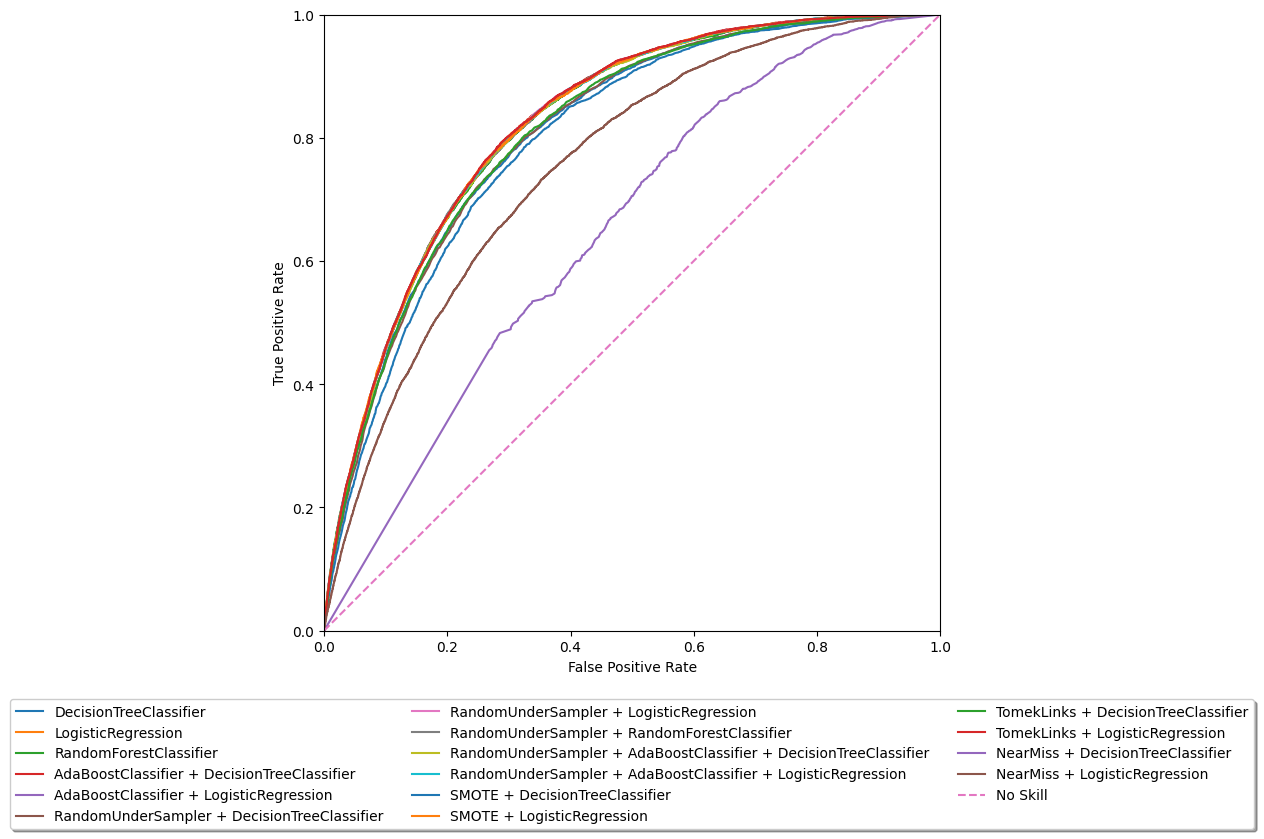

In [81]:
plot_auc_curve(models_score["model"], d_labels_test, d_attributes_test, models_score["model_descr"])

Here we can see that the ROC AUC scores of the models are very similar with some exceptions which means that we could expect a similar trade off between sensitivity and recall.  

Similarly PRC(precision recall curve) is a type of plot s a type of plot which illustrates the performance of a binary classifier system at all classification thresholds of the precision and recall metrics. This curve is the better choice when comparing models with unbalanced datasets because it does not look at the true negative rate.

In [82]:
def PRC(models, labels_test, attributes_test, label_names=["model_descr"]):
    """
    models          - list of models to be plotted
    labels_test     - labels to be used in calculation of the auc curve
    attributes_test - atributes to be used in calculation of the auc curve
    label_names     - names of the models 
    
    returns         - None
    """

    plt.gca().set_aspect('equal')

    for x in range(len(models)):

        try:
            lr_probs = models[x].predict_proba(attributes_test)
        except AttributeError:
            print("{} doest not have a PRC curve".format(label_names[x]))
            continue

        lr_probs = lr_probs[:, 1]

        precision, recall, thresholds = precision_recall_curve(
            labels_test, lr_probs)
        plt.plot(recall, precision, label=label_names[x])

    plt.rcParams["figure.figsize"] = (8, 8)
    plt.xlim(0, 1)
    plt.ylim(0, 1)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
    plt.legend(loc='upper center',
               bbox_to_anchor=(0.5, -0.1),
               fancybox=True,
               shadow=True,
               ncol=3)
    plt.gca().set_aspect('equal')

    plt.show()

In [83]:
PRC(models_score["model"], d_labels_test, d_attributes_test, models_score["model_descr"])

Here we can again see that most of the models have similar tradeoff between recall and precision.

#### Choosing a model 

As we said most of our models behave similarly and have similar scores and that is why we are not going to choose the model with the highest score but rather the model with the second higher $\mathrm{F}_1$ score or `AdaBoostClassifier + LogisticRegression`

In [84]:
models_score.iloc[4]

model_descr                      AdaBoostClassifier + LogisticRegression
optimisation_metric                                                   f1
recall                                                          0.770406
precision                                                       0.315126
f1                                                              0.447292
balanced_accuracy                                               0.749677
model                  (ColumnTransformer(remainder='passthrough',\n ...
Name: 4, dtype: object

We can look at the pipeline

In [85]:
chosen_model = models_score["model"][4]
chosen_model

Pipeline(memory='pipe_cashe',
         steps=[('column transofrmer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('BMI',
                                                  KBinsDiscretizer(encode='onehot-dense',
                                                                   subsample=None),
                                                  ['BMI']),
                                                 ('age',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['Age'])])),
                ('scaler', StandardScaler()),
                ('clf',
                 AdaBoostClassifier(base_estimator=LogisticRegression(class_weight='balanced',
                                                                      l1_ratio=0,
                                                                      penalty='elasticnet',
                                                                      solver='saga')))])

Let's see what hyperparameters were chosen with the grid search.

In [86]:
chosen_model.get_params()

{'memory': 'pipe_cashe',
 'steps': [('column transofrmer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('BMI',
                                    KBinsDiscretizer(encode='onehot-dense',
                                                     subsample=None),
                                    ['BMI']),
                                   ('age',
                                    OneHotEncoder(drop='first', sparse=False),
                                    ['Age'])])),
  ('scaler', StandardScaler()),
  ('clf',
   AdaBoostClassifier(base_estimator=LogisticRegression(class_weight='balanced',
                                                        l1_ratio=0,
                                                        penalty='elasticnet',
                                                        solver='saga')))],
 'verbose': False,
 'column transofrmer': ColumnTransformer(remainder='passthrough',
                   transformers=[('BMI',
                   

When we are using `AdaBoostClassifier` it is a lot harder to interpret the the feature importances so we are not going to do that.

We could look at the confusion matrix of our model once again.

In [87]:
cm = confusion_matrix(d_labels_test, chosen_model.predict(d_attributes_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

As we can see this model predicts a lot more false positives and far less false negative results than our baseline estimator. This is a good trade off since with the answers from the simple questionnaire we have build a model that has relatively high recall score. This means that most of the patients that have diabetes will be labeled as such. In order to avoid misdiagnosing a lot of healthy people with diabetes, additional tests could be preformed(e.g. blood test) to verify the diagnosis.

#### t-SNE

As we saw the results of are model are not very good. What we could try is try to visualise the result in two dimensions using the t-distributed stochastic neighbor embedding (t-SNE) method. 

Let's build a function that does that.

In [88]:
def fit_transform_pipe(pipe,
             train_atributes,
             train_labels,
             name=None,
             load_if_pickle_exists=True,
             save_pickle = True,
             save_folder=save_folder,
             file_extension=file_extension):
    """
    pipe                  - Pipe to fit_transform
    train_atributes       - atributes on which the pipe to be trained
    train_labels          - labels on which the pipe to be trained
    name                  - name of the file to load/save the pickle file
    load_if_pickle_exists - if True loads the pickle dump, rather than fit_transform the pipe
    save_pickle           - if True saves the fitted pipe
    save_folder           - destination to save/load the pickle file 
    file_extension        - extension of the pickle file to save/load
    
    returns               - results of the pipe.fit_transform
    """

        
    filename = save_folder + name + file_extension
    
    if (exists(filename)) & load_if_pickle_exists:
        fited_data = pickle.load(open(filename, 'rb'))
    else:
        fited_data = pipe.fit_transform(train_atributes, train_labels)
        if save_pickle:
            pickle.dump(fited_data, open(filename, 'wb'))

    return fited_data

In [89]:
pipline_steps = [
    ("column transofrmer", column_transformer),
    ("scaler", StandardScaler()),
    ('tsne', TSNE(n_components=2, n_jobs=-1)),
] 

pipe = Pipeline(pipline_steps)
tsne = fit_transform_pipe(pipe, d_attributes_train, d_labels_train, name="tsne")

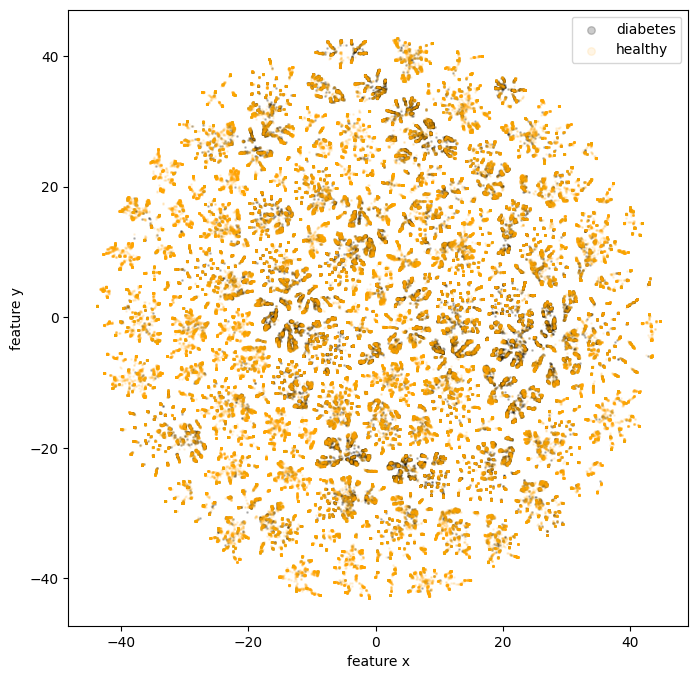

In [90]:
healthy = np.compress( d_labels_train ==0,tsne, axis=0)
diabetes = np.compress( d_labels_train ==1,tsne, axis=0)

scatter = plt.scatter(diabetes[:, 0], diabetes[:, 1],c = "black", label="diabetes", alpha=0.2, s=1)
scatter = plt.scatter(healthy[:, 0], healthy[:, 1],c= "orange", label="healthy", alpha=0.1, s=1)

plt.xlabel("feature x")
plt.ylabel("feature y")
lgnd = plt.legend()
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
plt.show()

We can see from the plot that there is no observable pattern of separation between the classes. There are regions, where very few positive labels could be observed, but there are none where the predominant feature is positive. 

## Conclusions

Using the data from the 2015 Behavioral Risk Factor Surveillance System survey, we have tested several estimators with different sampling techniques and managed to build a model that has relatively high recall score which means that most of the participants with diabetes will be labeled as such. The intention of this model is to be used as an indicator if a person should do any additional testing rather than having any diagnostic value. This is due to the high False Positive ratio.

It is very important to note here that this model is not a universal one, because there are a lot of biases in the data - some of the factors could be summarised as such

* Since this is a phone survey, there is a lot of selection, coverage and nonresponse bias for the participants
* Since this is a self-assess questionnaire there could be a errors in the answers of the participants
* We don't have any information about the race of the participants
* The diabetes rate and key factors vary from country to country

## Literature 

* https://scikit-learn.org/stable/index.html
* https://imbalanced-learn.org/stable/

* https://en.wikipedia.org/wiki/F-score
* https://en.wikipedia.org/wiki/Confusion_matrix
* https://effectivehealthcare.ahrq.gov/products/test-performance-metrics/appendixes
* https://towardsdatascience.com/metrics-and-python-ii-2e49597964ff
* https://towardsdatascience.com/imbalanced-classification-in-python-smote-tomek-links-method-6e48dfe69bbc

* https://neptune.ai/blog/how-to-deal-with-imbalanced-classification-and-regression-data
* https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/